# Objetivo del notebook

El notebook actual tiene como objetivo principal, proceder con el desarrollo del modelo final, ya con nuestros datos procesados. El notebook actual comprende unicamente la creacion de un modelo a partir del dataset procesado. No obstante, se plantea tambien el ensamblaje de varios modelos para tratar de garantizar un mejor desempenio del modelo final y, de paso, poner en practica esta caracteristica de construccion de modelos.

# Importar las librerias a utilizar

En las siguientes celdas, se importan todas las librerias externas y metodos especificos que son utilizados a lo largo del notebook.

In [2]:
# Librerias y metodos para analisis y manipulacion de datos
import numpy as np
import pandas as pd

# Clases y metodos de Sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier  # <-- LightGGM nop es de Scikit, sino de Microsoft
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, roc_curve, RocCurveDisplay, ConfusionMatrixDisplay, recall_score, roc_auc_score
from sklearn.utils import shuffle

# Librerias para visualizacion de datos
import matplotlib.pyplot as plt

# Otras librerias 
import os
import warnings
import random
import joblib
from imblearn.over_sampling import SMOTE
import time

warnings.filterwarnings(action='ignore')

# Carga del dataset procesado

In [3]:
# Defino un objeto DataFrame que cargue en memoria el dataset ya procesado, que generamos en el notebook anterior
dataset__route = "../../data/processed/processed__census_income.csv"
adult_df = pd.read_csv(dataset__route, low_memory=False)

# 5 primeros registros del dataset
adult_df.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,class
0,0.027397,0.083004,0.600000,0.0,0.0,0.193878,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1,0.328767,0.123678,0.800000,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
2,0.191781,0.094596,0.533333,0.0,0.0,0.500000,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
3,0.315068,0.128939,0.733333,0.0,0.0,0.448980,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
4,0.246575,0.058658,0.266667,0.0,0.0,0.377551,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1


In [4]:
adult_df.shape

(48842, 98)

# Creacion de subconjuntos de entrenamiento, test y validacion

Para la creacion de los subconjuntos de datos, voy a asignar las siguientes medidas:

* Conjunto entrenamiento ==>  80%

* Conjunto testing ==>  20%

***IMPORTANTE***. Es vital que el modelo no sufra desviacion hacia ninguna clase, y sea capaz de clasificar correctamente registros, con buena precision para ambas clases.

Es por esto que, antes de llevar a cabo la creacion de los subconjuntos de datos, me voy a asegurar que, al menos el subconjunto de entrenamiento, tenga clases balanceadas.

In [5]:
X = adult_df.drop(columns = ['class'])
y = adult_df['class']

In [6]:
print('Dimensiones de y ==>', y.shape)

indexes_y = y.value_counts().index
classes_y = y.value_counts().values
print('Ejemplos para cada clase:')
for index, class_ in zip(indexes_y, classes_y):
    print(index, '==>', class_)

Dimensiones de y ==> (48842,)
Ejemplos para cada clase:
1 ==> 37155
0 ==> 11687


In [7]:
# Instancio un objeto de la clase SMOTE para generar nuevos ejemplos de la clase minoritaria
oversample = SMOTE()

X, y = oversample.fit_resample(X, y)

In [8]:
print('Dimensiones de y ==>', y.shape)

indexes_y = y.value_counts().index
classes_y = y.value_counts().values
print('Ejemplos para cada clase:')
for index, class_ in zip(indexes_y, classes_y):
    print(index, '==>', class_)

Dimensiones de y ==> (74310,)
Ejemplos para cada clase:
1 ==> 37155
0 ==> 37155


In [90]:
## Genero los subconjuntos de datos
# Randomizo nuevamente los datos
X, y = shuffle(X, y, random_state = 42) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
#X_train, X_val, y_train, y_val = train_test_split(X_entrenamiento, y_entrenamiento, test_size=.1)

In [91]:
print("CONJUNTO ENTRENAMIENTO:")
print(X_train.shape, y_train.shape)

CONJUNTO ENTRENAMIENTO:
(59448, 74) (59448,)


In [11]:
#print("CONJUNTO VALIDACION:")
#print(X_val.shape, y_val.shape)

In [12]:
print("CONJUNTO TESTING:")
print(X_test.shape, y_test.shape)

CONJUNTO TESTING:
(14862, 97) (14862,)


## Reviso el balanceo de clases en el conjunto de entrenamiento

In [13]:
indexes_y_train = y_train.value_counts().index
classes_y_train = y_train.value_counts().values
print('Ejemplos para cada clase [ENTRENAMIENTO]:')
for index, class_ in zip(indexes_y_train, classes_y_train):
    print(index, '==>', class_)

Ejemplos para cada clase [ENTRENAMIENTO]:
1 ==> 29752
0 ==> 29696


# Modelo de clasificacion

A continuacion, voy a instanciar un modelo LightGBM y optimizar algunos de sus hiperparametros con GridSearchCV.

In [14]:
# Instancio el modelo LGBMClassifier
model_1 = LGBMClassifier(random_state=42, device_type = 'gpu', objective = 'binary', verbose_eval=False)
# Defino un diccionario de parametros a optimizar
param_grid = {
    'learning_rate': [0.05], # Taxa de aprendizaje. Valores comunes van de 0.01 a 0.2
    'n_estimators': [1200], # Número de árboles a construir.
    'num_leaves': [31], # Número máximo de nodos hoja en un árbol. Valores típicos van de 20 a 40
    'max_depth': [-1], # Máxima profundidad de cada árbol. -1 significa sin límite.
    'subsample': [0.8],
    'colsample_bytree': [0.4], # Fracción de características a considerar para cada árbol.
    'min_data_in_leaf': [20],
    'gpu_use_dp': [True],
    'max_bin': [255]
}

# Instancio un objeto de la clase GridSearchCV
grid_cv_1 = GridSearchCV(model_1, param_grid)

# Entreno el modelo con el conjunto de entrenamiento
inicio_modelo_1 = time.time()
grid_cv_1.fit(X_train, y_train)
fin_modelo_1 = time.time()
tiempo_modelo_1 = fin_modelo_1 - inicio_modelo_1

[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 23801, number of negative: 23757
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4582
[LightGBM] [Info] Number of data points in the train set: 47558, number of used features: 92
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 7 dense feature groups (0.36 MB) transferred to GPU in 0.000602 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.50

In [15]:
# Parametros del mejor modelo
best_params_1 = grid_cv_1.best_params_

# Mejor modelo entrenado
best_model_1 = grid_cv_1.best_estimator_

print('Parametros del mejor modelo entrenado ==>', best_params_1)

Parametros del mejor modelo entrenado ==> {'colsample_bytree': 0.4, 'gpu_use_dp': True, 'learning_rate': 0.05, 'max_bin': 255, 'max_depth': -1, 'min_data_in_leaf': 20, 'n_estimators': 1200, 'num_leaves': 31, 'subsample': 0.8}


# Inferencias sobre nuevos ejemplos

Utilizo el mejor modelo para predecir una etiqueta para los ejemplos que el modelo no ha visto durante el entrenamiento, los cuales se encuentran en el conjunto de testing.

In [16]:
## Predicciones del modelo
y_pred_1 = best_model_1.predict(X_test)

# Primeras 10 etiquetas para el conjunto de testing
print(y_pred_1[:10])

[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[0 1 0 0 0 0 1 1 0 1]


# Evaluando el modelo entrenado

In [17]:
print('Accuracy:', best_model_1.score(X_test, y_test))

[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Accuracy: 0.909298883057462


In [18]:
# Matriz de confusion y cuadro de metricas
conf_matrix = confusion_matrix(y_test, y_pred_1)
class_report = classification_report(y_test, y_pred_1)

print(conf_matrix)
print(class_report)

[[6727  732]
 [ 616 6787]]
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      7459
           1       0.90      0.92      0.91      7403

    accuracy                           0.91     14862
   macro avg       0.91      0.91      0.91     14862
weighted avg       0.91      0.91      0.91     14862



# Guardo el modelo entrenado

In [19]:
#model__route = '../../src/models/'
#joblib.dump(best_model, os.path.join(model__route, 'final_model__LightGBM.joblib'))

#print('Modelo guardado con exito.')

# Creacion de un meta modelo

Me gustaria probar a desarrollar un meta-modelo que combinase otros 3 modelos LightGBM, para tratar de aumentar un poco el rendimiento final.

En las siguientes celdas, se aplican todos los pasos necesarios para poder desarrollar un meta-estimador que combine 3 modelos LightGBM.

## Entrenamiento de los nuevos modelos

Para el meta-modelo, voy a hacer uso del modelo ya entrenado, y otros 2 modelos mas, los cuales se basaran, uno en el mismo algoritmo, y otro en el algoritmo RandoForestClassifier, de SkLearn.

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
model_2 = LGBMClassifier(random_state=42, device_type = 'gpu', objective = 'binary', verbose_eval=False)
# Defino un diccionario de parametros a optimizar
param_grid = {
    'learning_rate': [0.01, 0.15, 0.2], # Taxa de aprendizaje. Valores comunes van de 0.01 a 0.2
    'n_estimators': [1000, 1200, 1500], # Número de árboles a construir.
    'num_leaves': [35], # Número máximo de nodos hoja en un árbol. Valores típicos van de 20 a 40
    'max_depth': [-1], # Máxima profundidad de cada árbol. -1 significa sin límite.
    'subsample': [0.8],
    'colsample_bytree': [0.4, 0.6, 0.8], # Fracción de características a considerar para cada árbol.
    'min_data_in_leaf': [30],
    'gpu_use_dp': [True],
    'max_bin': [255]
}

# Instancio un objeto de la clase GridSearchCV
grid_cv_2 = GridSearchCV(model_2, param_grid, verbose = False)

inicio_modelo_2 = time.time()
# Entreno el modelo con el conjunto de entrenamiento
grid_cv_2.fit(X_train, y_train)
fin_modelo_2 = time.time()
tiempo_modelo_2 = fin_modelo_2 - inicio_modelo_2

[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Number of positive: 23826, number of negative: 23732
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4540
[LightGBM] [Info] Number of data points in the train set: 47558, number of used features: 86
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 7 dense feature groups (0.36 MB) transferred to GPU in 0.000650 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.50

In [22]:
model_3 = RandomForestClassifier(n_estimators=100, random_state=42)

inicio_modelo_3 = time.time()
model_3.fit(X_train, y_train)
fin_modelo_3 = time.time()
tiempo_modelo_3 = fin_modelo_3 - inicio_modelo_3

In [23]:
# Obtenemos las predicciones de los modelos
preds_1 = grid_cv_1.best_estimator_.predict_proba(X_val)[:, 1]
preds_2 = grid_cv_2.best_estimator_.predict_proba(X_val)[:, 1]
preds_3 = model_3.predict_proba(X_val)[:, 1]

# Creamos el nuevo conjunto de entrenamiento para el meta-modelo
X_new = np.column_stack((preds_1, preds_2, preds_3))

[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


In [24]:
# Entrenamos el meta-modelo
meta_model = LogisticRegression(random_state=42)

inicio_modelo_meta = time.time()
meta_model.fit(X_new, y_val)
fin_modelo_meta = time.time()
tiempo_modelo_meta = fin_modelo_meta - inicio_modelo_meta

#### Tiempos de entrenamiento de los modelos

Es importante para la documentacion del proyecto poder medir el tiempo de entrenamiento total del meta-modelo. La siguiente celda muestra el tiempo de entrenamiento de cada uno de los modelos que conforman realmente el ensamblaje.

In [25]:
print('TIEMPOS DE ENTRENAMIENTO (en segundos):')
print('Modelo 1 (LightGBM) ==>', tiempo_modelo_1)
print('Modelo 2 (LightGBM) ==>', tiempo_modelo_2)
print('Modelo 3 (RandomForestClassifier) ==>', tiempo_modelo_3)
print('Modelo meta (LogisticRegression) ==>', tiempo_modelo_meta)

TIEMPOS DE ENTRENAMIENTO (en segundos):
Modelo 1 (LightGBM) ==> 32.45630717277527
Modelo 2 (LightGBM) ==> 800.1534745693207
Modelo 3 (RandomForestClassifier) ==> 5.790100812911987
Modelo meta (LogisticRegression) ==> 0.015501976013183594


In [26]:
# Aquí asumimos que X_test es tu conjunto de datos de prueba
preds_1_test = grid_cv_1.best_estimator_.predict_proba(X_test)[:, 1]
preds_2_test = grid_cv_2.best_estimator_.predict_proba(X_test)[:, 1]
preds_3_test = model_3.predict_proba(X_test)[:, 1]

X_test_new = np.column_stack((preds_1_test, preds_2_test, preds_3_test))

# Finalmente, hacemos las predicciones con el meta-modelo
final_predictions = meta_model.predict(X_test_new)

[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


In [27]:
final_predictions[-100:]

array([1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0], dtype=int64)

In [28]:
meta_model.classes_

array([0, 1], dtype=int64)

## Hiperparametros de los modelos

In [29]:
print('HIPERPARAMETROS DE LOS MODELOS:')
print('Modelo 1 (LightGBM) ==>', grid_cv_1.best_params_)
print('Modelo 2 (LightGBM) ==>', grid_cv_2.best_params_)
print('Modelo 3 (RandomForestClassifier) ==>')
print('Theta Modelo meta (LogisticRegression) ==>')
print('Bias Modelo meta (LogisticRegression) ==>')

HIPERPARAMETROS DE LOS MODELOS:
Modelo 1 (LightGBM) ==> {'colsample_bytree': 0.4, 'gpu_use_dp': True, 'learning_rate': 0.05, 'max_bin': 255, 'max_depth': -1, 'min_data_in_leaf': 20, 'n_estimators': 1200, 'num_leaves': 31, 'subsample': 0.8}
Modelo 2 (LightGBM) ==> {'colsample_bytree': 0.4, 'gpu_use_dp': True, 'learning_rate': 0.15, 'max_bin': 255, 'max_depth': -1, 'min_data_in_leaf': 30, 'n_estimators': 1000, 'num_leaves': 35, 'subsample': 0.8}
Modelo 3 (RandomForestClassifier) ==>
Theta Modelo meta (LogisticRegression) ==>
Bias Modelo meta (LogisticRegression) ==>


## Coeficientes de los modelos entrenados 


In [31]:
print('COEFICIENTES DE THETA:')
print('Modelo 1 (LightGBM) ==>', grid_cv_1.best_estimator_.feature_importances_)
print('Modelo 2 (LightGBM) ==>', grid_cv_2.best_estimator_.feature_importances_)
print('Modelo 3 (RandomForestClassifier) ==>', model_3.feature_importances_)
print('Theta Modelo meta (LogisticRegression) ==>', meta_model.coef_)
print('Bias Modelo meta (LogisticRegression) ==>', meta_model.intercept_)

COEFICIENTES DE THETA:
Modelo 1 (LightGBM) ==> [5866 4343 1950 2962 1918 4010  310  373    0  660  270  479   35  109
  136   53   74  137   72  122  178  482   86  556  211    3  119  438
  302   64  580  311  138  144  405    0  383  516  186  163  271  258
   37  490  229  448  255  487  509  100  292  342  217  238   57  433
  544  149   38   61   34   34    5   14   38   39   61   36   10    4
    0    0   18   11   57   19   35   49   13   45    0   94   13   10
   32   75   26   43   58    6   54   15    2   25  380   31   15]
Modelo 2 (LightGBM) ==> [5248 5361 2353 1785 1348 4112  294  346    0  713  210  428    0   78
  112   52   48   98   63  160  184  492   70  594  253    0   86  583
  304   59  497  349  116  114  292    0  353  433  133  114  199  177
   12  475  144  338  239  494  485  107  243  270  162  295   58  408
  542  136   28   17   53   19    0   20   39   27   49   59    6   21
    0    0    0    0   68   34   56   61   14   45    0   76    4    0
   12   63

## Evaluando el rendimiento del ensamblaje final

F1 Score del ensamblaje: 0.903
Precision del ensamblaje: 0.898
Sensibilidad (recall) del ensamblaje 0.908


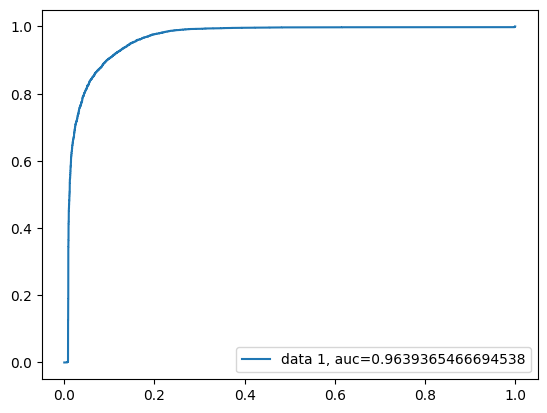

In [32]:
print('F1 Score del ensamblaje:', round(f1_score(y_test, final_predictions), 3))
print('Precision del ensamblaje:', round(precision_score(y_test, final_predictions), 3))
print('Sensibilidad (recall) del ensamblaje', round(recall_score(y_test, final_predictions), 3))

y_pred_proba = meta_model.predict_proba(X_test_new)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.savefig('../../src/visualization/modeling/metrics/roc_auc_first_ensemble.png')
plt.show()

In [33]:
conf_matrix = confusion_matrix(y_test, final_predictions)
class_report = classification_report(y_test, final_predictions)

print(conf_matrix)
print(class_report)

[[6696  763]
 [ 684 6719]]
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      7459
           1       0.90      0.91      0.90      7403

    accuracy                           0.90     14862
   macro avg       0.90      0.90      0.90     14862
weighted avg       0.90      0.90      0.90     14862



Matriz de confusion
[[6696  763]
 [ 684 6719]]
Matriz de confusion normalizada
[[0.9  0.1 ]
 [0.09 0.91]]


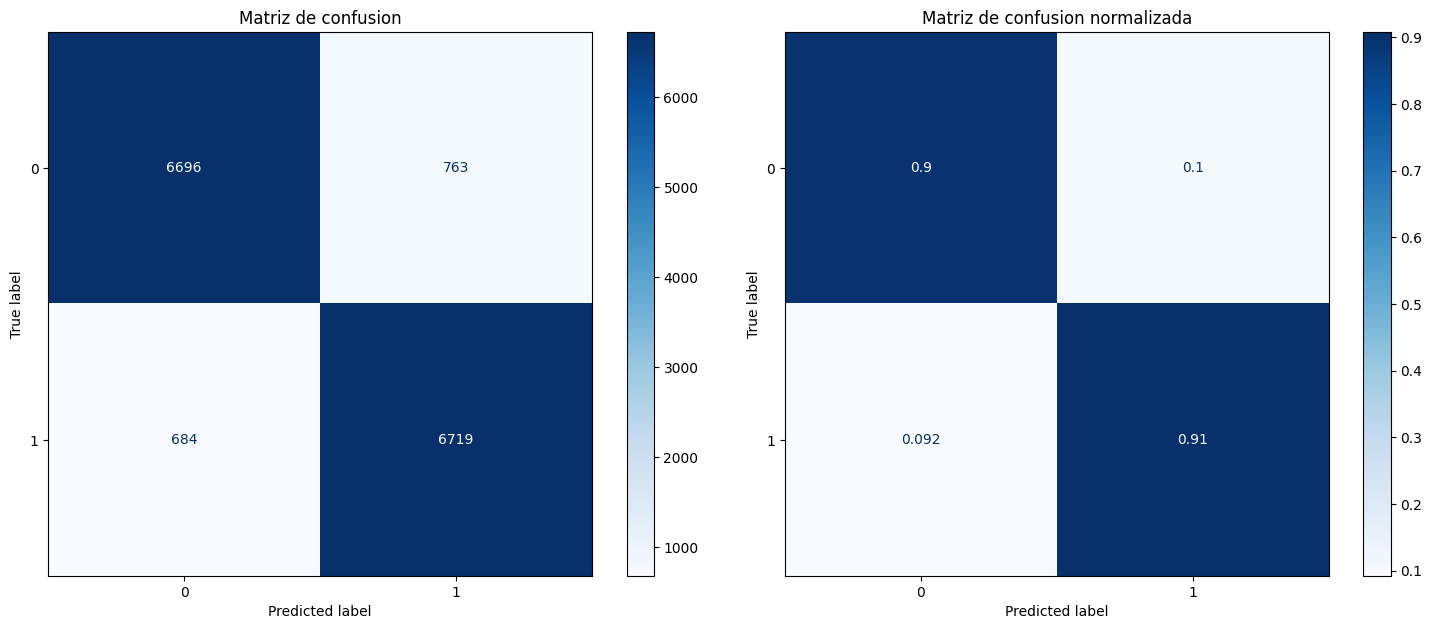

In [34]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [
    ("Matriz de confusion", None),
    ("Matriz de confusion normalizada", "true"),
]

fig, axs = plt.subplots(1, 2, figsize = (15, 6))
for idx, (title, normalize) in enumerate(titles_options):
    disp = ConfusionMatrixDisplay.from_estimator(
        meta_model,
        X_test_new,
        y_test,
        display_labels=[0, 1],
        cmap=plt.cm.Blues,
        normalize=normalize,
        ax=axs[idx]  # Usamos el índice para asignar el eje actual
    )
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

plt.tight_layout()
plt.savefig('../../src/visualization/modeling/metrics/conf_matrix_first_ensemble.png')
plt.show()

Finalmente, vemos como el meta-modelo entrenado con un ensamblaje de modelos LightGBM y RandomForest, obtiene un rendimiento ligeramente superior al de cada uno de los modelos LightGBM por separado.

# UPDATE. Ingenieria caracteristicas

Revisando los coeficientes de los modelos entrenados, he podido comprobar para exiten algunas caracteristicas que tienen muy poca relevancia para el modelo, o incluso ni siquiera aportan informacion.

Voy a actualizar el dataset, eliminando estas caracteristicas, y tratare de entrenar desde 0 modelos basados en los mismos algoritmos que hasta ahora. Es probable que al eliminar estas variables, el modelo ahora sea capaz de hacer mejores predicciones, incrementando, aunque sea un poco el rendimiento final.

In [45]:
# Lista con los indices de las columnas irrelevantes
columns_to_delete = [8, 12, 25, 35, 60, 61, 62, 63, 67, 68, 69, 70, 71, 72, 73, 76, 78, 83, 86, 90, 93, 94, 96]

adult_df = adult_df.drop(adult_df.columns[columns_to_delete], axis = 1)  # Columnas eliminadas!

In [46]:
adult_df

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native-country_Nicaragua,native-country_Peru,native-country_Philippines,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_Taiwan,native-country_Thailand,native-country_Vietnam,class
0,0.027397,0.083004,0.600000,0.000000,0.0,0.193878,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.328767,0.123678,0.800000,0.000000,0.0,0.500000,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.191781,0.094596,0.533333,0.000000,0.0,0.500000,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.315068,0.128939,0.733333,0.000000,0.0,0.448980,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.246575,0.058658,0.266667,0.000000,0.0,0.377551,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,0.438356,0.073299,0.800000,0.278283,0.0,0.602041,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
48838,0.205479,0.131467,0.800000,0.000000,0.0,0.602041,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
48839,0.342466,0.129861,0.600000,0.000000,0.0,0.397959,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
48840,0.794521,0.068725,1.000000,0.000000,0.0,0.193878,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### Reanudo el proceso de generacion de caracteristicas

In [47]:
X = adult_df.drop(columns = ['class'])
y = adult_df['class']

In [48]:
# Instancio un objeto de la clase SMOTE para generar nuevos ejemplos de la clase minoritaria
oversample = SMOTE()

X, y = oversample.fit_resample(X, y)

In [49]:
print('Dimensiones de y ==>', y.shape)

indexes_y = y.value_counts().index
classes_y = y.value_counts().values
print('Ejemplos para cada clase:')
for index, class_ in zip(indexes_y, classes_y):
    print(index, '==>', class_)

Dimensiones de y ==> (74310,)
Ejemplos para cada clase:
1 ==> 37155
0 ==> 37155


In [78]:
X, y = shuffle(X, y, random_state = 42) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [51]:
indexes_y_train = y_train.value_counts().index
classes_y_train = y_train.value_counts().values
print('Ejemplos para cada clase [ENTRENAMIENTO]:')
for index, class_ in zip(indexes_y_train, classes_y_train):
    print(index, '==>', class_)

Ejemplos para cada clase [ENTRENAMIENTO]:
0 ==> 29749
1 ==> 29699


## Entrenamiento de los nuevos modelos LightGBM

In [52]:
# Instancio el modelo LGBMClassifier
model_1__2 = LGBMClassifier(random_state=42, device_type = 'gpu', objective = 'binary', verbose_eval=False)
# Defino un diccionario de parametros a optimizar
param_grid = {
    'learning_rate': [0.05, 0.1, 0.15], # Taxa de aprendizaje. Valores comunes van de 0.01 a 0.2
    'n_estimators': [800, 1000, 1200], # Número de árboles a construir.
    'num_leaves': [31], # Número máximo de nodos hoja en un árbol. Valores típicos van de 20 a 40
    'max_depth': [-1], # Máxima profundidad de cada árbol. -1 significa sin límite.
    'subsample': [0.8],
    'colsample_bytree': [0.4, 0.6, 0.8], # Fracción de características a considerar para cada árbol.
    'min_data_in_leaf': [20],
    'gpu_use_dp': [True],
    'max_bin': [255]
}

# Instancio un objeto de la clase GridSearchCV
grid_cv_1__2 = GridSearchCV(model_1__2, param_grid, verbose = False)

# Entreno el modelo con el conjunto de entrenamiento
inicio_modelo_1 = time.time()
grid_cv_1__2.fit(X_train, y_train)
fin_modelo_1 = time.time()
tiempo_modelo_1 = fin_modelo_1 - inicio_modelo_1

[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 23759, number of negative: 23799
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4033
[LightGBM] [Info] Number of data points in the train set: 47558, number of used features: 72
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 7 dense feature groups (0.36 MB) transferred to GPU in 0.000516 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.49

In [53]:
# Parametros del mejor modelo
best_params_1__2 = grid_cv_1__2.best_params_

# Mejor modelo entrenado
best_model_1__2 = grid_cv_1__2.best_estimator_

print('Parametros del mejor modelo entrenado ==>', best_params_1__2)

Parametros del mejor modelo entrenado ==> {'colsample_bytree': 0.4, 'gpu_use_dp': True, 'learning_rate': 0.05, 'max_bin': 255, 'max_depth': -1, 'min_data_in_leaf': 20, 'n_estimators': 1000, 'num_leaves': 31, 'subsample': 0.8}


In [54]:
## Predicciones del modelo
y_pred_1__2 = best_model_1__2.predict(X_test)

# Primeras 10 etiquetas para el conjunto de testing
print(y_pred_1__2[:10])

[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[1 0 1 1 1 1 0 1 1 0]


In [55]:
# Matriz de confusion y cuadro de metricas
conf_matrix = confusion_matrix(y_test, y_pred_1__2)
class_report = classification_report(y_test, y_pred_1__2)

print(conf_matrix)
print(class_report)

[[6634  772]
 [ 654 6802]]
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      7406
           1       0.90      0.91      0.91      7456

    accuracy                           0.90     14862
   macro avg       0.90      0.90      0.90     14862
weighted avg       0.90      0.90      0.90     14862



### Segundo modelo LightGDM

In [92]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
model_2__2 = LGBMClassifier(random_state=42, device_type = 'gpu', objective = 'binary', verbose_eval=False)
# Defino un diccionario de parametros a optimizar
param_grid = {
    'learning_rate': [0.01, 0.15, 0.2], # Taxa de aprendizaje. Valores comunes van de 0.01 a 0.2
    'n_estimators': [1000, 1200, 1500], # Número de árboles a construir.
    'num_leaves': [35], # Número máximo de nodos hoja en un árbol. Valores típicos van de 20 a 40
    'max_depth': [-1], # Máxima profundidad de cada árbol. -1 significa sin límite.
    'subsample': [0.8],
    'colsample_bytree': [0.4, 0.6, 0.8], # Fracción de características a considerar para cada árbol.
    'min_data_in_leaf': [30],
    'gpu_use_dp': [True],
    'max_bin': [255]
}

# Instancio un objeto de la clase GridSearchCV
grid_cv_2__2 = GridSearchCV(model_2__2, param_grid, verbose = False)

inicio_modelo_2 = time.time()
# Entreno el modelo con el conjunto de entrenamiento
grid_cv_2__2.fit(X_train, y_train)
fin_modelo_2 = time.time()
tiempo_modelo_2 = fin_modelo_2 - inicio_modelo_2

[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Number of positive: 23826, number of negative: 23732
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4026
[LightGBM] [Info] Number of data points in the train set: 47558, number of used features: 71
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 7 dense feature groups (0.36 MB) transferred to GPU in 0.000493 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.50

## Tercer modelo

In [104]:
model_3__2 = RandomForestClassifier(n_estimators=1800, random_state=42)

inicio_modelo_3 = time.time()
model_3__2.fit(X_train, y_train)
fin_modelo_3 = time.time()
tiempo_modelo_3 = fin_modelo_3 - inicio_modelo_3

In [105]:
# Obtenemos las predicciones de los modelos
preds_1 = grid_cv_1__2.best_estimator_.predict_proba(X_val)[:, 1]
preds_2 = grid_cv_2__2.best_estimator_.predict_proba(X_val)[:, 1]
preds_3 = model_3__2.predict_proba(X_val)[:, 1]

# Creamos el nuevo conjunto de entrenamiento para el meta-modelo
X_new = np.column_stack((preds_1, preds_2, preds_3))

[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


In [106]:
# Entrenamos el meta-modelo
meta_model__2 = LogisticRegression(random_state=42)

inicio_modelo_meta = time.time()
meta_model__2.fit(X_new, y_val)
fin_modelo_meta = time.time()
tiempo_modelo_meta = fin_modelo_meta - inicio_modelo_meta

In [107]:
print('TIEMPOS DE ENTRENAMIENTO (en segundos):')
print('Modelo 1 (LightGBM) ==>', tiempo_modelo_1)
print('Modelo 2 (LightGBM) ==>', tiempo_modelo_2)
print('Modelo 3 (RandomForestClassifier) ==>', tiempo_modelo_3)
print('Modelo meta (LogisticRegression) ==>', tiempo_modelo_meta)

TIEMPOS DE ENTRENAMIENTO (en segundos):
Modelo 1 (LightGBM) ==> 567.6838927268982
Modelo 2 (LightGBM) ==> 791.2731463909149
Modelo 3 (RandomForestClassifier) ==> 85.4232485294342
Modelo meta (LogisticRegression) ==> 0.007999181747436523


In [108]:
# Aquí asumimos que X_test es tu conjunto de datos de prueba
preds_1_test = grid_cv_1__2.best_estimator_.predict_proba(X_test)[:, 1]
preds_2_test = grid_cv_2__2.best_estimator_.predict_proba(X_test)[:, 1]
preds_3_test = model_3__2.predict_proba(X_test)[:, 1]

X_test_new = np.column_stack((preds_1_test, preds_2_test, preds_3_test))

# Finalmente, hacemos las predicciones con el meta-modelo
final_predictions__2 = meta_model__2.predict(X_test_new)

[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


In [115]:
print('HIPERPARAMETROS DE LOS MODELOS:')
print('Modelo 1 (LightGBM) ==>', grid_cv_1__2.best_params_)
print('Modelo 2 (LightGBM) ==>', grid_cv_2__2.best_params_)
print('Modelo 3 (RandomForestClassifier) ==>', model_3__2.get_params)
print('Modelo meta (LogisticRegression) ==>', meta_model__2.get_params)

HIPERPARAMETROS DE LOS MODELOS:
Modelo 1 (LightGBM) ==> {'colsample_bytree': 0.4, 'gpu_use_dp': True, 'learning_rate': 0.05, 'max_bin': 255, 'max_depth': -1, 'min_data_in_leaf': 20, 'n_estimators': 1000, 'num_leaves': 31, 'subsample': 0.8}
Modelo 2 (LightGBM) ==> {'colsample_bytree': 0.4, 'gpu_use_dp': True, 'learning_rate': 0.15, 'max_bin': 255, 'max_depth': -1, 'min_data_in_leaf': 30, 'n_estimators': 1000, 'num_leaves': 35, 'subsample': 0.8}
Modelo 3 (RandomForestClassifier) ==> <bound method BaseEstimator.get_params of RandomForestClassifier(n_estimators=1800, random_state=42)>
Modelo meta (LogisticRegression) ==> <bound method BaseEstimator.get_params of LogisticRegression(random_state=42)>


In [116]:
print('COEFICIENTES DE THETA:')
print('Modelo 1 (LightGBM) ==>', grid_cv_1__2.best_estimator_.feature_importances_)
print('Modelo 2 (LightGBM) ==>', grid_cv_2__2.best_estimator_.feature_importances_)
print('Modelo 3 (RandomForestClassifier) ==>', model_3__2.feature_importances_)
print('Theta Modelo meta (LogisticRegression) ==>', meta_model__2.coef_)
print('Bias Modelo meta (LogisticRegression) ==>', meta_model__2.intercept_)

COEFICIENTES DE THETA:
Modelo 1 (LightGBM) ==> [4916 3667 1649 2685 1409 3469  292  309  523  210  395  112   96   25
   45  163   64  126  147  340   77  425  207   99  356  274   68  462
  293  141  107  330  260  449  230  149  196  268   37  406  187  341
  225  380  388   94  240  309  200  234   59  359  515  172   31   57
   69   40   38   42   10   69   48    0  142   28   33   53   53   62
    0   11   20   15]
Modelo 2 (LightGBM) ==> [5267 5874 2054 1866 1449 3794  340  352  729  179  434  114   96   44
   43   95   63  149  193  487   69  633  248  115  590  341   44  444
  326  111  134  296  393  577  144  116  173  212   17  521  152  379
  262  531  468  117  270  310  189  246   49  341  580  159   34   22
   60   50   59   78   47   81   53    0   92    5   15   78   62   48
    0   24    0   13]
Modelo 3 (RandomForestClassifier) ==> [1.63e-01 1.24e-01 6.05e-02 7.04e-02 1.78e-02 1.01e-01 4.61e-03 5.50e-03
 1.08e-02 4.84e-03 6.94e-03 1.73e-03 3.22e-03 8.45e-04 8.99e-04 

F1 Score del ensamblaje: 0.951
Precision del ensamblaje: 0.95
Sensibilidad (recall) del ensamblaje 0.953


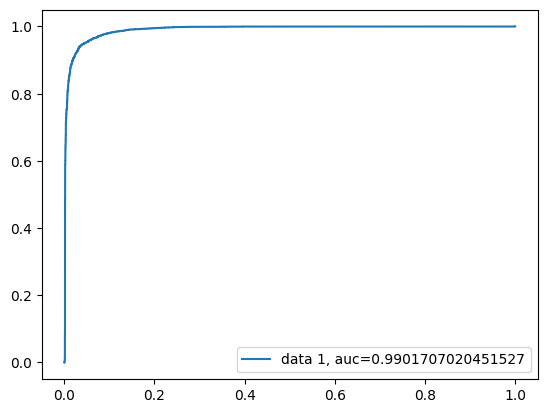

In [111]:
print('F1 Score del ensamblaje:', round(f1_score(y_test, final_predictions__2), 3))
print('Precision del ensamblaje:', round(precision_score(y_test, final_predictions__2), 3))
print('Sensibilidad (recall) del ensamblaje', round(recall_score(y_test, final_predictions__2), 3))

y_pred_proba = meta_model__2.predict_proba(X_test_new)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.savefig('../../src/visualization/modeling/metrics/roc_auc_second_ensemble.png')
plt.show()

In [112]:
conf_matrix = confusion_matrix(y_test, final_predictions__2)
class_report = classification_report(y_test, final_predictions__2)

print(conf_matrix)
print(class_report)

[[7159  369]
 [ 344 6990]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      7528
           1       0.95      0.95      0.95      7334

    accuracy                           0.95     14862
   macro avg       0.95      0.95      0.95     14862
weighted avg       0.95      0.95      0.95     14862



Matriz de confusion
[[6929  599]
 [ 510 6824]]
Matriz de confusion normalizada
[[0.92 0.08]
 [0.07 0.93]]


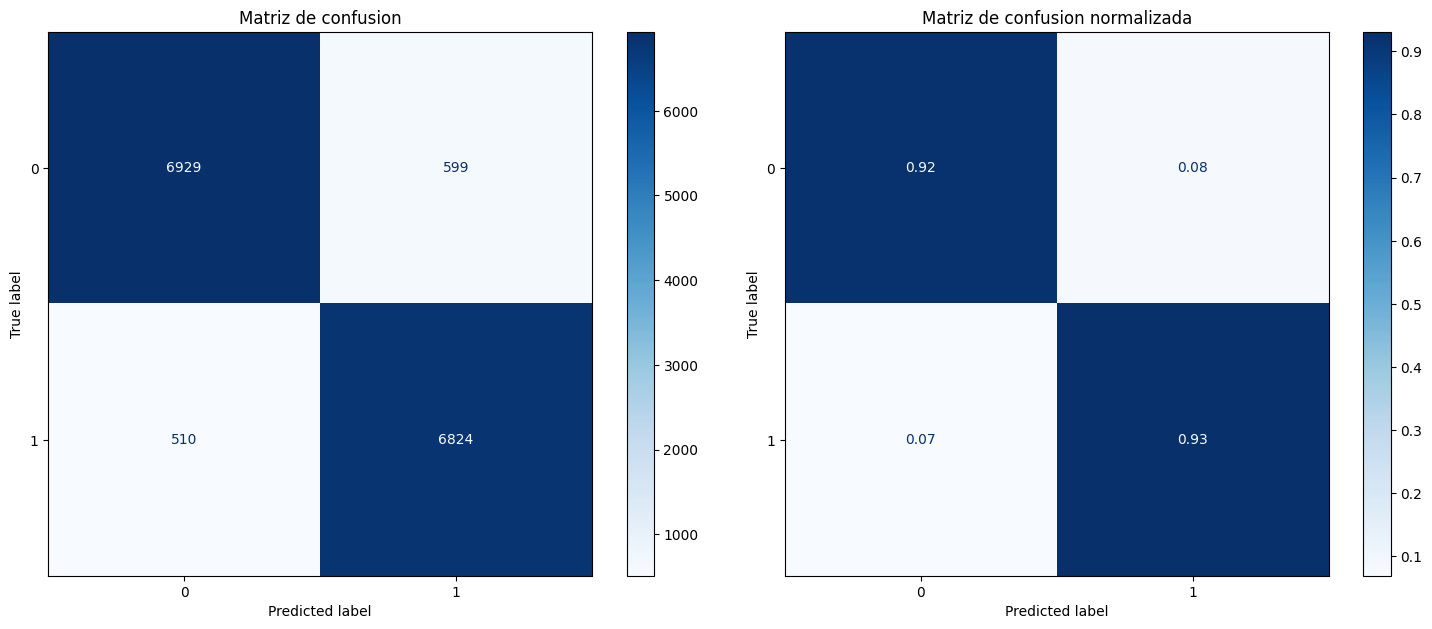

In [113]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [
    ("Matriz de confusion", None),
    ("Matriz de confusion normalizada", "true"),
]

fig, axs = plt.subplots(1, 2, figsize = (15, 6))
for idx, (title, normalize) in enumerate(titles_options):
    disp = ConfusionMatrixDisplay.from_estimator(
        meta_model__2,
        X_test_new,
        y_test,
        display_labels=[0, 1],
        cmap=plt.cm.Blues,
        normalize=normalize,
        ax=axs[idx]  # Usamos el índice para asignar el eje actual
    )
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

plt.tight_layout()
plt.savefig('../../src/visualization/modeling/metrics/conf_matrix_second_ensemble.png')
plt.show()

Los resultados obtenidos ahora por los nuevos modelos entrenados son ligeramente mejores que los resultados obtenidos por los modelos originales.

Voy a guardar estos modelos, y los usare en el ensamblaje del modelo final.

# Guardo el meta-modelo final

**IMPORTANTE**. Este ensamblaje de modelos esta compuesto por 4 modelos individuales, por lo que deberemos guardar cada uno de los modelos, y cargarlos para generar el stacking cuando vayamos a hacer uso de este (como un todo, un unico modelo) para generar predicciones.

In [114]:
dataset__route = '../../src/models/ensemble/'

if not os.path.exists(dataset__route):
    os.mkdir(dataset__route)

joblib.dump(grid_cv_1__2.best_estimator_, os.path.join(dataset__route, 'ensemble_model_1.joblib'))
joblib.dump(grid_cv_2__2.best_estimator_, os.path.join(dataset__route, 'ensemble_model_2.joblib'))
joblib.dump(model_3__2, os.path.join(dataset__route, 'ensemble_model_3.joblib'))
joblib.dump(meta_model__2, os.path.join(dataset__route, 'ensemble_meta_model.joblib'))

print('Modelos guardados con exito.')

Modelos guardados con exito.
